# Adquisicion, limpieza y manejo de los datos

#### Importante: Si no deseas replicar la parte de adquisicion de los datos mediante web scraping, sigue las notas indicadas al principio de cada apartado del notebook

# Importar librerias

In [1]:
from bs4 import BeautifulSoup as BS
import requests
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
import re
from datetime import datetime


pd.options.display.max_rows = None
pd.options.display.max_columns = None

#### Resumen Web Scraping
* Se extraen por separado las estadisitcas intrinsecas de los peleadores y el listado de las peleas y eventos de UFC
* Posteriormente se unirán para usar las estadisticas de los peleadroes para predecir el resultado

#### Descripcion de las variables que se obtiene del webscraping
SLpM - Significant Strikes Landed per Minute 

Str. Acc. - Significant Striking Accuracy 

SApM - Significant Strikes Absorbed per Minute

Str. Def. - Significant Strike Defence (the % of opponents strikes that did not land)

TD Avg. - Average Takedowns Landed per 15 minutes

TD Acc. - Takedown Accuracy

TD Def. - Takedown Defense (the % of opponents TD attempts that did not land)

Sub. Avg. - Average Submissions Attempted per 15 minutes 

# 1. Scraping Fighters
#### Si quieres usar el dataset proporcionado en el link de la memoria pasad al apartado 1.1

* Scraping pagina estadisticas peleadores ufc: http://ufcstats.com/statistics/fighters

In [5]:
# guardamos una lista de caracteres para poder variar la página de la web de la UFC

abecedario = string.ascii_lowercase
fighters_df_list = []
for letra in abecedario:
    fighter_letra_link = f'http://ufcstats.com/statistics/fighters?char={letra}&page=all'
    
    #Obtenemos la tabla de peleadores cuyo nombre empieza por la letra
    df_fighters = pd.read_html(fighter_letra_link)[0]
    df_fighters.dropna(how = 'all', axis = 0, inplace = True)
    df_fighters.reset_index(drop=True, inplace = True)
    
    #Agregamos los enlaces a la pagina de cada peleador para obtener 
    #posteriormente sus estadisticas estaticas
    response = requests.get(fighter_letra_link)
    soup = BS(response.text)
    enlaces = []
    for tr in soup.find_all('tr')[2:]:
        enlace = tr.find('a')['href']
        enlaces.append(enlace)
    df_fighters['enlaces'] = pd.Series(enlaces)

    fighters_df_list.append(df_fighters)

peleadores = pd.concat(fighters_df_list)
peleadores.shape

(3922, 12)

In [6]:
peleadores.head()

,First,Last,Nickname,Ht.,Wt.,Reach,Stance,W,L,D,Belt,enlaces
0,Tom,Aaron,NaN,--,155 lbs.,--,NaN,5.0,3.0,0.0,NaN,http://ufcstats.com/fighter-details/93fe7332d1...
1,Danny,Abbadi,The Assassin,"5' 11""",155 lbs.,--,Orthodox,4.0,6.0,0.0,NaN,http://ufcstats.com/fighter-details/15df64c02b...
2,Nariman,Abbasov,Bayraktar,"5' 8""",155 lbs.,"66.0""",Orthodox,28.0,4.0,0.0,NaN,http://ufcstats.com/fighter-details/59a9d6dac6...
3,David,Abbott,Tank,"6' 0""",265 lbs.,--,Switch,10.0,15.0,0.0,NaN,http://ufcstats.com/fighter-details/b361180739...
4,Hamdy,Abdelwahab,The Hammer,"6' 2""",264 lbs.,"72.0""",Southpaw,6.0,0.0,0.0,NaN,http://ufcstats.com/fighter-details/3329d692ae...


* Scraping de las estadisticas de cada peleador con el enlace recogido en la anterior fase

In [9]:
stats = []
for link in peleadores['enlaces']:
    try:
        #pausa de 1 segundos para evitar saturacion del servidor
        time.sleep(1)
        response = requests.get(link)
        soup = BS(response.text)
        stats_peleador = {}
        for li in soup.find_all('li')[3:17]:
            lista = li.text.replace('\n', ' ').strip().split(':')
            lista = [elemento.strip() for elemento in lista]
            if len(lista[0]) != 0:
                stats_peleador[lista[0]] = lista[1]
    except:
        #pausa de 10 segundos para evitar de nuevo el error de conexion
        time.sleep(10)
        response = requests.get(link)
        soup = BS(response.text)
        stats_peleador = {}
        for li in soup.find_all('li')[3:17]:
            lista = li.text.replace('\n', ' ').strip().split(':')
            lista = [elemento.strip() for elemento in lista]
            if len(lista[0]) != 0:
                stats_peleador[lista[0]] = lista[1]
            
    stats.append(stats_peleador)        
df_stats = pd.DataFrame(stats)

1

2

3

4

5

6

7

8

9

10

11

12

13

14

15

16

17

18

19

20

21

22

23

24

25

26

27

28

29

30

31

32

33

34

35

36

37

38

39

40

41

42

43

44

45

46

47

48

49

50

51

52

53

54

55

56

57

58

59

60

61

62

63

64

65

66

67

68

69

70

71

72

73

74

75

76

77

78

79

80

81

82

83

84

85

86

87

88

89

90

91

92

93

94

95

96

97

98

99

100

101

102

103

104

105

106

107

108

109

110

111

112

113

114

115

116

117

118

119

120

121

122

123

124

125

126

127

128

129

130

131

132

133

134

135

136

137

138

139

140

141

142

143

144

145

146

147

148

149

150

151

152

153

154

155

156

157

158

159

160

161

162

163

164

165

166

167

168

169

170

171

172

173

174

175

176

177

178

179

180

181

182

183

184

185

186

187

188

189

190

191

192

193

194

195

196

197

198

199

200

201

202

203

204

205

206

207

208

209

210

211

212

213

214

215

216

217

218

219

220

221

222

1551

1552

1553

1554

1555

1556

1557

1558

1559

1560

1561

1562

1563

1564

1565

1566

1567

1568

1569

1570

1571

1572

1573

1574

1575

1576

1577

1578

1579

1580

1581

1582

1583

1584

1585

1586

1587

1588

1589

1590

1591

1592

1593

1594

1595

1596

1597

1598

1599

1600

1601

1602

1603

1604

1605

1606

1607

1608

1609

1610

1611

1612

1613

1614

1615

1616

1617

1618

1619

1620

1621

1622

1623

1624

1625

1626

1627

1628

1629

1630

1631

1632

1633

1634

1635

1636

1637

1638

1639

1640

1641

1642

1643

1644

1645

1646

1647

1648

1649

1650

1651

1652

1653

1654

1655

1656

1657

1658

1659

1660

1661

1662

1663

1664

1665

1666

1667

1668

1669

1670

1671

1672

1673

1674

1675

1676

1677

1678

1679

1680

1681

1682

1683

1684

1685

1686

1687

1688

1689

1690

1691

1692

1693

1694

1695

1696

1697

1698

1699

1700

1701

1702

1703

1704

1705

1706

1707

1708

1709

1710

1711

1712

1713

1714

1715

1716

1717

2917

2918

2919

2920

2921

2922

2923

2924

2925

2926

2927

2928

2929

2930

2931

2932

2933

2934

2935

2936

2937

2938

2939

2940

2941

2942

2943

2944

2945

2946

2947

2948

2949

2950

2951

2952

2953

2954

2955

2956

2957

2958

2959

2960

2961

2962

2963

2964

2965

2966

2967

2968

2969

2970

2971

2972

2973

2974

2975

2976

2977

2978

2979

2980

2981

2982

2983

2984

2985

2986

2987

2988

2989

2990

2991

2992

2993

2994

2995

2996

2997

2998

2999

3000

3001

3002

3003

3004

3005

3006

3007

3008

3009

3010

3011

3012

3013

3014

3015

3016

3017

3018

3019

3020

3021

3022

3023

3024

3025

3026

3027

3028

3029

3030

3031

3032

3033

3034

3035

3036

3037

3038

3039

3040

3041

3042

3043

3044

3045

3046

3047

3048

3049

3050

3051

3052

3053

3054

3055

3056

3057

3058

3059

3060

3061

3062

3063

3064

3065

3066

3067

3068

3069

3070

3071

3072

3073

3074

3075

3076

3077

3078

3079

3080

3081

3082

3083

In [10]:
df_stats.head()

,Height,Weight,Reach,STANCE,DOB,SLpM,Str. Acc.,SApM,Str. Def,TD Avg.,TD Acc.,TD Def.,Sub. Avg.
0,--,155 lbs.,--,,"Jul 13, 1978",0.00,0%,0.00,0%,0.00,0%,0%,0.0
1,"5' 11""",155 lbs.,--,Orthodox,"Jul 03, 1983",3.29,38%,4.41,57%,0.00,0%,77%,0.0
2,"5' 8""",155 lbs.,"66""",Orthodox,"Feb 01, 1994",3.00,20%,5.67,46%,0.00,0%,66%,0.0
3,"6' 0""",265 lbs.,--,Switch,--,1.35,30%,3.55,38%,1.07,33%,66%,0.0
4,"6' 2""",264 lbs.,"72""",Southpaw,"Jan 22, 1993",3.87,52%,3.13,59%,3.00,75%,0%,0.0


* Union del dataset de fighters y estadisicas

In [11]:
peleadores.reset_index(drop=True, inplace=True)
fighter_stats_df = pd.concat([peleadores, df_stats], axis = 1)
## Se guarda el dataset que se compartira en un drive para replicar el proyecto
fighter_stats_df.to_csv('fighter_stats.csv', index=False)

In [16]:
fighter_stats_df.head()

,First,Last,Nickname,Ht.,Wt.,Reach,Stance,W,L,D,Belt,enlaces,Height,Weight,Reach,STANCE,DOB,SLpM,Str. Acc.,SApM,Str. Def,TD Avg.,TD Acc.,TD Def.,Sub. Avg.
0,Tom,Aaron,NaN,--,155 lbs.,--,NaN,5.0,3.0,0.0,NaN,http://ufcstats.com/fighter-details/93fe7332d1...,--,155 lbs.,--,,"Jul 13, 1978",0.00,0%,0.00,0%,0.00,0%,0%,0.0
1,Danny,Abbadi,The Assassin,"5' 11""",155 lbs.,--,Orthodox,4.0,6.0,0.0,NaN,http://ufcstats.com/fighter-details/15df64c02b...,"5' 11""",155 lbs.,--,Orthodox,"Jul 03, 1983",3.29,38%,4.41,57%,0.00,0%,77%,0.0
2,Nariman,Abbasov,Bayraktar,"5' 8""",155 lbs.,"66.0""",Orthodox,28.0,4.0,0.0,NaN,http://ufcstats.com/fighter-details/59a9d6dac6...,"5' 8""",155 lbs.,"66""",Orthodox,"Feb 01, 1994",3.00,20%,5.67,46%,0.00,0%,66%,0.0
3,David,Abbott,Tank,"6' 0""",265 lbs.,--,Switch,10.0,15.0,0.0,NaN,http://ufcstats.com/fighter-details/b361180739...,"6' 0""",265 lbs.,--,Switch,--,1.35,30%,3.55,38%,1.07,33%,66%,0.0
4,Hamdy,Abdelwahab,The Hammer,"6' 2""",264 lbs.,"72.0""",Southpaw,6.0,0.0,0.0,NaN,http://ufcstats.com/fighter-details/3329d692ae...,"6' 2""",264 lbs.,"72""",Southpaw,"Jan 22, 1993",3.87,52%,3.13,59%,3.00,75%,0%,0.0


## 1.1. Limpieza dataset fighters
### Empezar desde aquí si quieres replicar el proyecto con el dataset compartido por drive

* Se limpian los datos del dataset de fighters y se hace el analisis univariado de las variables

In [139]:
fighters = pd.read_csv('./fighter_stats.csv')

In [140]:
# Funciones creadas para la limpieza y manejo de los datos

def pies_a_cm(distancia_pies):
    '''
    Funcion para pasar de pies a centimetros:
    
    distancia_pies: Es un string con el valor de pies y pulgadas
    
    Se comprueba si es un str para mantener los NA
    Se comprueba la longitud del string para diferenciar si esta en pies
    y pulgadas o solo pulgadas
    
    Se devuelve la altura en centimetros redondeada a la unidad.    
    
    '''
    
    if type(distancia_pies) == str:
        if len(distancia_pies)>3:
            digits = re.findall('[0-9]+', distancia_pies)
            pies, pulgadas = re.findall('[0-9]+', distancia_pies)
            cm = round(float(pies) * 30.48 + float(pulgadas) * 2.54)
        elif len(distancia_pies) == 3:
            pulgadas = re.findall('[0-9]+', distancia_pies)[0]
            cm = round(float(pulgadas) * 2.54)
        else:
            cm = np.nan
        return cm
    else:
        return np.nan


def delete_percentage(serie):
     '''
    Funcion para eliminar el caracter de porcentaje junto con apply
    
    '''
    return serie.str[:-1]


# Funciones lambda para sustituir guiones por NA y formatear la fecha
delete_guion = lambda x: np.nan if x == '--' else x
date_parse_v1 = lambda x: np.nan if (x == '--' or type(x) != str) else datetime.strptime(x, '%b %d, %Y')

In [141]:

# Se sustituyen los NAs de nombre por un string vacio
fighters['First'].fillna('', inplace=True)

# Se une el nombre y el apellido para usarlo como identificador
fighters['Full Name'] = fighters['First'] + ' ' + fighters['Last']

# Se ajustan las unidades de las variables
fighters['Reach'] = fighters['Reach.1'].apply(pies_a_cm)
fighters['Height'] = fighters['Height'].apply(pies_a_cm)
fighters['Weight'] = fighters['Weight'].str[:3]

# Eliminar caracteres %
cols_per = ['Str. Acc.', 'Str. Def', 'TD Acc.', 'TD Def.']
fighters[cols_per] = fighters[cols_per].apply(delete_percentage)

#Se seleccionan las variables de interes
fighters = fighters[['Full Name','Height', 'Weight','Reach', 'DOB', 
         'Stance', 'W', 'L', 'D',  'SLpM',
         'Str. Acc.', 'SApM', 'Str. Def', 'TD Avg.',
         'TD Acc.', 'TD Def.', 'Sub. Avg.']]

#Ajuste de la variable de fecha y sustitucion de '--' por NA
fighters['DOB'] = fighters['DOB'].apply(date_parse_v1)
fighters['Weight'] = fighters['Weight'].apply(delete_guion)

# Hacemos las columnas numericas
fighters['Weight'] = pd.to_numeric(fighters['Weight'], errors='coerce')
fighters['Str. Acc.'] = pd.to_numeric(fighters['Str. Acc.'], errors='coerce')
fighters['Str. Def'] = pd.to_numeric(fighters['Str. Def'], errors='coerce')
fighters['TD Acc.'] = pd.to_numeric(fighters['TD Acc.'], errors='coerce')
fighters['TD Def.'] = pd.to_numeric(fighters['TD Def.'], errors='coerce')

# Calculo variable edad
now = datetime.now()
fighters['today'] = np.full(len(fighters['DOB']), now, dtype='datetime64[ns]')
fighters['edad'] = fighters['today'].dt.year - fighters['DOB'].dt.year
fighters.drop(['today'], axis = 1, inplace = True)

fighters.head()

,Full Name,Height,Weight,Reach,DOB,Stance,W,L,D,SLpM,Str. Acc.,SApM,Str. Def,TD Avg.,TD Acc.,TD Def.,Sub. Avg.,edad
0,Tom Aaron,NaN,155.0,NaN,1978-07-13,NaN,5.0,3.0,0.0,0.00,0,0.00,0,0.00,0,0,0.0,45.0
1,Danny Abbadi,180.0,155.0,NaN,1983-07-03,Orthodox,4.0,6.0,0.0,3.29,38,4.41,57,0.00,0,77,0.0,40.0
2,Nariman Abbasov,173.0,155.0,168.0,1994-02-01,Orthodox,28.0,4.0,0.0,3.00,20,5.67,46,0.00,0,66,0.0,29.0
3,David Abbott,183.0,265.0,NaN,NaT,Switch,10.0,15.0,0.0,1.35,30,3.55,38,1.07,33,66,0.0,NaN
4,Hamdy Abdelwahab,188.0,264.0,183.0,1993-01-22,Southpaw,6.0,0.0,0.0,3.87,52,3.13,59,3.00,75,0,0.0,30.0


* Tras una limpiza preliminar de los datos hacemos un analisis descriptivo de las variables obtenidas

In [142]:
fighters.describe()

,Height,Weight,Reach,W,L,D,SLpM,Str. Acc.,SApM,Str. Def,TD Avg.,TD Acc.,TD Def.,Sub. Avg.,edad
count,3650.000000,3846.000000,2000.000000,3922.000000,3922.000000,3922.000000,3922.000000,3922.000000,3922.000000,3922.000000,3922.000000,3922.000000,3922.000000,3922.000000,3178.000000
mean,178.298082,171.435257,181.980500,12.385263,5.784804,0.269505,2.376678,35.282509,3.071328,42.540286,1.246015,26.301377,38.758287,0.632305,38.312775
std,8.808546,39.754295,10.698614,9.487759,5.150685,0.837488,1.935681,20.547846,2.760490,22.603950,1.955285,28.888982,34.387670,1.595805,7.434979
min,152.000000,105.000000,147.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,19.000000
25%,173.000000,145.000000,175.000000,6.000000,2.000000,0.000000,0.800000,26.000000,1.530000,35.000000,0.000000,0.000000,0.000000,0.000000,33.000000
50%,178.000000,170.000000,183.000000,11.000000,5.000000,0.000000,2.270000,40.000000,2.870000,50.000000,0.570000,22.000000,42.000000,0.000000,38.000000
75%,185.000000,185.000000,190.000000,17.000000,8.000000,0.000000,3.530000,49.000000,4.120000,58.000000,1.930000,45.000000,66.000000,0.700000,43.000000
max,226.000000,770.000000,213.000000,253.000000,83.000000,11.000000,22.110000,100.000000,52.500000,100.000000,32.140000,100.000000,100.000000,23.700000,80.000000


* La edad se ha calculado a fecha actual (20/01/2023) por lo que habria que calcularla en el momento de la pelea
* Hay NAs en varias variables


In [143]:
def missing_data_table(data):
     '''
    Funcion para crear una tabla ordenada por las varibles con mas valores faltantes.
    
    data: Dataframe
    
    '''
    total = data.isnull().sum().sort_values(ascending=False)
    percent = data.isnull().sum()/data.isnull().count() * 100
    missing_data = pd.concat([total, percent.round(2)], axis=1, keys=['Total', 'Percent'])
    return missing_data

missing_data_table(fighters)

,Total,Percent
Reach,1922,49.01
Stance,821,20.93
edad,744,18.97
DOB,744,18.97
Height,272,6.94
Weight,76,1.94
Str. Def,0,0.00
Sub. Avg.,0,0.00
TD Def.,0,0.00
TD Acc.,0,0.00


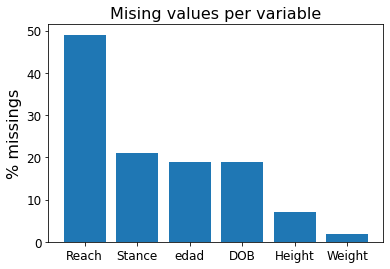

In [145]:
#Representamos un grafico de barras con las variables con mas missings
na_counts = missing_data_table(fighters)
plt.rcParams['font.size'] = 12
plt.figure()
plt.title('Mising values per variable', fontsize = 16)
plt.ylabel('% missings', fontsize = 16)
plt.bar(na_counts.index[:6], na_counts['Percent'][:6]);

* Estudiamos la distribucion y relacion de las variables para determinar si podemos sustituir los missings de algunas variables como 'Reach' o 'Stance' que tienen un gran numero de NAs

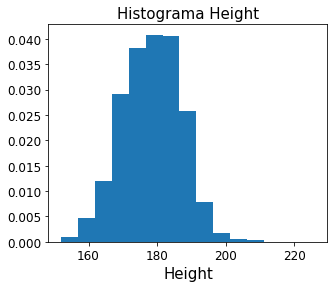

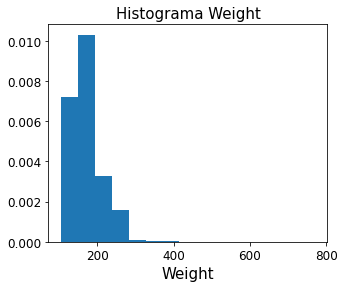

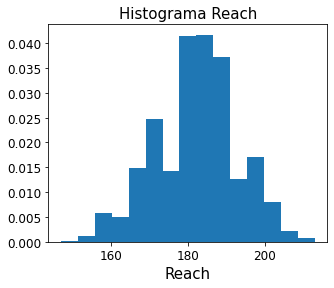

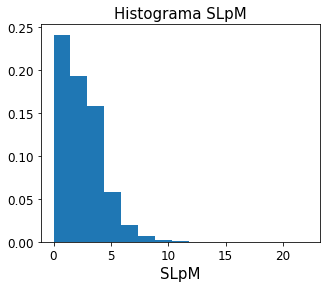

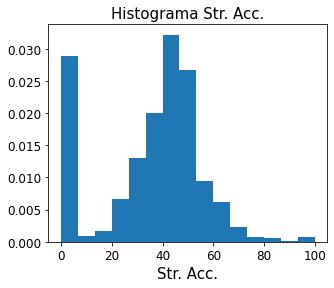

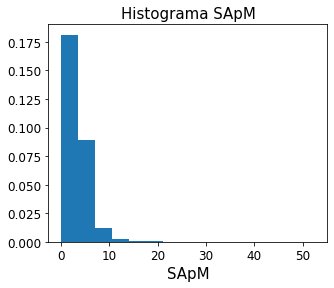

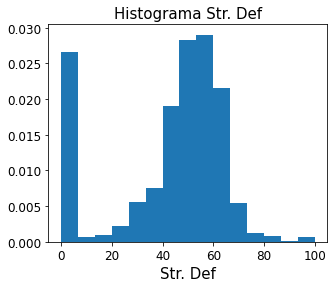

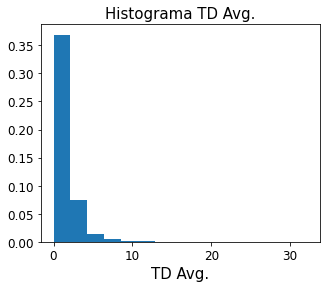

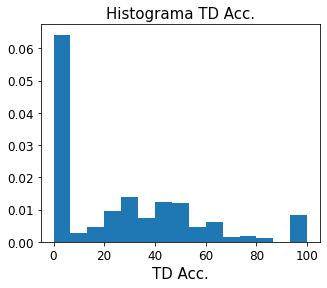

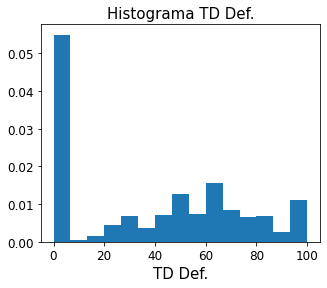

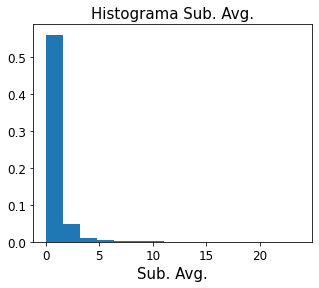

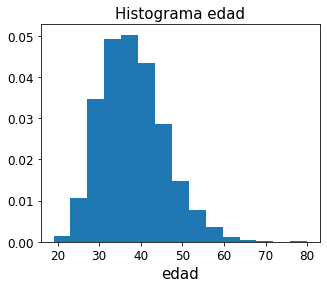

In [147]:
def plot_hist(col, bins = 30, title = '', xlabel = '', fontsize = 15, ax = None, range = None):
     '''
    Funcion para representar un histograma ajustando el formato
    
    col = columna del dataset a representar
    
    '''
    
    ax.set_title(f'Histograma {title}', fontsize = fontsize)
    ax.set_xlabel(xlabel, fontsize = fontsize)
    ax.hist(col, bins = bins, density = True);   

    
#Visualizacion de los histogramas usando la funcion previamente creada    
fighters_stats = ['Height', 'Weight', 'Reach','SLpM', 'Str. Acc.', 'SApM', 'Str. Def', 'TD Avg.', 'TD Acc.',
       'TD Def.', 'Sub. Avg.', 'edad']

for stat in fighters_stats:
        
    fig, ax = plt.subplots(figsize = (5,4))
    plot_hist(fighters[stat],
              bins = 15,
             title = f'{stat}',
             xlabel = stat,
             ax = ax)

In [148]:
#Calculo media y mediana edad
mean_edad = fighters['edad'].mean()
median_edad = fighters['edad'].median()

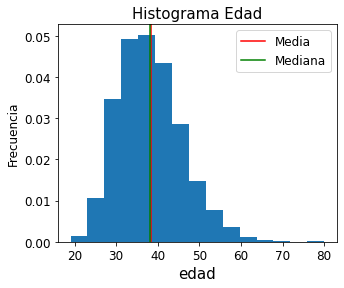

In [150]:
#Histograma Edad
fig, ax = plt.subplots(figsize = (5,4))
plot_hist(fighters['edad'],
        bins = 15,
        title = 'Edad',
        xlabel = stat,
        ax = ax)
plt.axvline(mean_edad, color = 'red', label = 'Media')
plt.axvline(median_edad, color = 'green', label = 'Mediana')
plt.ylabel('Frecuencia')
plt.legend();

In [151]:
#Calculo media y mediana altura
mean_edad = fighters['Height'].mean()
median_edad = fighters['Height'].median()

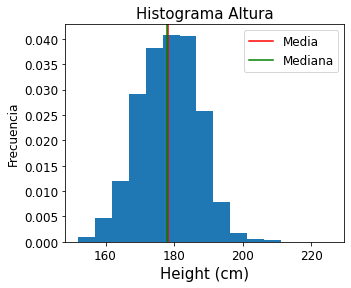

In [152]:
#Histograma Altura
fig, ax = plt.subplots(figsize = (5,4))
plot_hist(fighters['Height'],
        bins = 15,
        title = 'Altura',
        xlabel = 'Height (cm)',
        ax = ax)
plt.axvline(mean_edad, color = 'red', label = 'Media')
plt.axvline(median_edad, color = 'green', label = 'Mediana')
plt.ylabel('Frecuencia')
plt.legend();

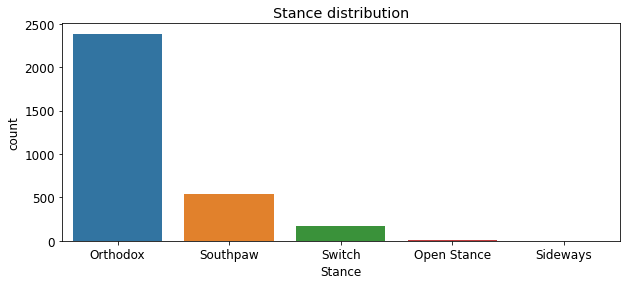

In [153]:
#Countplot de las guardias de los peleadores
fig, ax = plt.subplots(figsize = (10,4))
plt.title('Stance distribution')
plt.xlabel('Stance')
plt.ylabel('Count')
frequencias = fighters['Stance'].value_counts()
sns.countplot(data = fighters, x = 'Stance', order = frequencias.index)
plt.show()

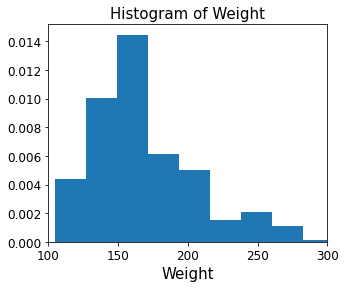

In [154]:
# Peso ajustando los limites quitando valores extremos
fig, ax = plt.subplots(figsize = (5,4))
ax.set_title(f'Histogram of Weight', fontsize = 15)
ax.set_xlabel('Weight', fontsize = 15)
plt.xlim(100,300)
ax.hist(fighters['Weight'], bins = 30, density = True); 


#### Stance
* La mayor parte de los peleadores emplean una guardia ortodoxa 

#### Hegiht y Reach
* A la vista sigue una distribucion normal, se podrian sustituir los NAs por la altura media (otra opcion seria ver la distribucion segun el peso de la division de peso) o ver la relacion entre ambas ya que anatomicamente suelen estar relacionadas

#### Weight
* A la vista sigue una distribucion normal. Con una cola larga en los pesos altos, tiene sentido ya que hay un menor numero de peleadores profesionales Heavyweight

#### Str. Acc, Str. Def,  TD Acc., TD def
* Las variables que representan un porcentaje de precion o golpeo muestran una gran cantidad de valores cercanos a cero



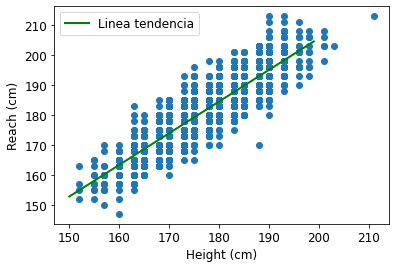

In [156]:
#Scatter plot para ver la relacion entre las variables Height y Fighters
df_NoNas = fighters.dropna().copy()

a, b = np.polyfit(df_NoNas['Height'], df_NoNas['Reach'], 1)
x = range(150, 200, 1)
y = a*x+b
plt.scatter(fighters['Height'], fighters['Reach'])
plt.xlabel('Height (cm)')
plt.ylabel('Reach (cm)')
plt.plot(x, y, 'g', linewidth=2, label = 'Linea tendencia')
plt.legend();

#### Hegiht y Reach
* Confirmamos la teoria de que anatomicamente la altura suele coincidir con la envergadura (Alcance)

In [158]:
#Distrubucion de la variable Altura en relacion a la categoria de peso
divisiones_peso = [0, 115, 125, 135, 145, 155, 170, 185, 205, 265, 1000]
labels = ['0-115', '115-125', '125-135', '135-145', '145-155', '155-170', '170-185', '185-205', '205-265', '+265']
df = fighters[['Height', 'Weight']].copy()
df['categoria'] = pd.cut(df['Weight'], bins=divisiones_peso, labels=labels)

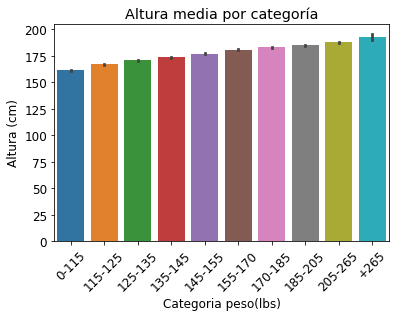

In [160]:
plt.title('Altura media por categoría')
sns.barplot(data = df, x= 'categoria', y= 'Height')
plt.xlabel('Categoria peso(lbs)')
plt.ylabel('Altura (cm)')
plt.xticks(rotation=45);

* Se sustituyen los NAs de altura por la media de su rango de peso, y los de reach por el valor de la altura
* Se sustituyen los NAs de Stance por Orthodox
* Se sustituyen los NAs de la edad por la media (se adaptará a la fecha en la que ocurriera la pelea)
* Se eliminan el resto ya que no son un porcentaje considerable de la N total de peleadores

In [161]:
fighters['Stance'] = fighters['Stance'].fillna('Orthodox')

divisiones_peso = [0, 115, 125, 135, 145, 155, 170, 185, 205, 265, 1000]
for i in range(len(divisiones_peso)-1):
    mask = (fighters['Weight']>divisiones_peso[i]) & (fighters['Weight']<=divisiones_peso[i+1])
    media_altura_div = round(fighters[mask]['Height'].mean(), 2)
    fighters.loc[mask, 'Height'] = fighters.loc[mask, 'Height'].fillna(media_altura_div)

fighters.loc[fighters['Reach'].isnull(), 'Reach'] = fighters['Height'].copy()

fighters['edad'] = fighters['edad'].fillna(fighters['edad'].mean())

In [162]:
missing_data_table(fighters)

,Total,Percent
DOB,744,18.97
Weight,76,1.94
Reach,70,1.78
Height,70,1.78
Full Name,0,0.00
SApM,0,0.00
Sub. Avg.,0,0.00
TD Def.,0,0.00
TD Acc.,0,0.00
TD Avg.,0,0.00


In [163]:
# Se elimina la variable DOB que no sera necesaria y se eliminan
# el resto de peleas con NAs (aprox 2%)
fighters.drop(['DOB'], axis = 1, inplace = True)
fighters.dropna(inplace = True) 

In [164]:
fighters.shape

(3846, 17)

In [165]:
missing_data_table(fighters)

,Total,Percent
Full Name,0,0.0
Str. Acc.,0,0.0
Sub. Avg.,0,0.0
TD Def.,0,0.0
TD Acc.,0,0.0
TD Avg.,0,0.0
Str. Def,0,0.0
SApM,0,0.0
SLpM,0,0.0
Height,0,0.0


In [219]:
#Se eliminan peleador duplicados en la obtencion de los datos
fighters.drop_duplicates(subset=['Full Name'], inplace = True)

In [220]:
#Guardamos el data set
fighters.to_csv('fighter_stats.csv', index=False)

In [221]:
fighters = pd.read_csv('./fighter_stats.csv')

In [222]:
fighters.head(1)

,Full Name,Height,Weight,Reach,Stance,W,L,D,SLpM,Str. Acc.,SApM,Str. Def,TD Avg.,TD Acc.,TD Def.,Sub. Avg.,edad
0,Tom Aaron,176.77,155.0,176.77,Orthodox,5.0,3.0,0.0,0.0,0,0.0,0,0.0,0,0,0.0,45.0


# 2. Scraping bouts min
### Pasa al punto 2.1 si quieres replicar el proyecto con el dataset proporcionado en el link de la memoria

* Scraping pagina eventos ufc: http://ufcstats.com/statistics/events/completed

In [135]:
# Obtenemos todos los eventos
bouts_link = 'http://ufcstats.com/statistics/events/completed?page=all'
events_v2 = pd.read_html(bouts_link)[0]

In [136]:
# Se eliminan las filas correspondientes a eventos futuros
events_v2.drop([0,1], inplace=True)
events_v2.reset_index(drop=True, inplace=True)
events_v2.head()

,Name/date,Location
0,UFC Fight Night: Lewis vs. Spivac February 04...,"Las Vegas, Nevada, USA"
1,"UFC 283: Teixeira vs. Hill January 21, 2023","Rio de Janeiro, Rio de Janeiro, Brazil"
2,UFC Fight Night: Strickland vs. Imavov Januar...,"Las Vegas, Nevada, USA"
3,UFC Fight Night: Cannonier vs. Strickland Dec...,"Las Vegas, Nevada, USA"
4,"UFC 282: Blachowicz vs. Ankalaev December 10,...","Las Vegas, Nevada, USA"


In [137]:
events_v2.shape

(633, 2)

* Obtenemos los enlaces de cada evento realizado

In [138]:
response = requests.get(bouts_link)
soup = BS(response.text)
scrap_table = soup.find('tbody')
rows = scrap_table.find_all('a')
event_link = []
for row in rows[1:]:
    event = row['href']
    event_link.append(event)
    
    
events_v2['link']= pd.Series(event_link)

In [139]:
events_v2.head()

,Name/date,Location,link
0,UFC Fight Night: Lewis vs. Spivac February 04...,"Las Vegas, Nevada, USA",http://ufcstats.com/event-details/d26394fc0e8e...
1,"UFC 283: Teixeira vs. Hill January 21, 2023","Rio de Janeiro, Rio de Janeiro, Brazil",http://ufcstats.com/event-details/5717efc6f271...
2,UFC Fight Night: Strickland vs. Imavov Januar...,"Las Vegas, Nevada, USA",http://ufcstats.com/event-details/2e2cdb6e9eb8...
3,UFC Fight Night: Cannonier vs. Strickland Dec...,"Las Vegas, Nevada, USA",http://ufcstats.com/event-details/56ec58954158...
4,"UFC 282: Blachowicz vs. Ankalaev December 10,...","Las Vegas, Nevada, USA",http://ufcstats.com/event-details/f65a0eb902f9...


* Obtenemos los datos da cada una de las peleas de cada evento usando el link previamente extraido

In [141]:
peleas_por_evento = []
for i in range(len(events_v2['link'])):
    response = requests.get(events_v2['link'][i])
    soup = BS(response.text)
    links_peleas = pd.Series([tr['data-link'] for tr in soup.find_all('tr')[1:]], name = 'link')
    fights = pd.read_html(events_v2['link'][i])[0]
    fecha = pd.Series(np.full(len(links_peleas), events_v2['Name/date'][i]), name = 'date_fight')
    fights_with_link = pd.concat([fights,fecha, links_peleas], axis = 1)
    peleas_por_evento.append(fights_with_link)
    time.sleep(1) # Evita bloqueo del servidor
    
bouts = pd.concat(peleas_por_evento, axis=0)
bouts.reset_index(drop=True, inplace=True)

#Guardamos los datos obtenidos del scraping
bouts.to_csv('bouts_min_inicial.csv', index = False)
bouts.head()

ConnectionResetError: [Errno 104] Connection reset by peer

## 2.1. Limpieza dataset bouts
## Comenzar desde aquí si usaras el dataset proporcionado

In [ ]:
bouts = pd.read_csv('./bouts_min_inicial.csv')

* Siempre aparece como ganado el primer peleador, eliminamos empates y nulos por ser muy pocos casos

In [133]:
bouts['W/L'].unique()

array(['win'], dtype=object)

In [64]:
mask = bouts['W/L'] != 'win'
index = bouts[mask].index
bouts.drop(index, inplace = True)

In [65]:
bouts['W/L'].unique()

array(['win'], dtype=object)

In [66]:
bouts.shape

(6841, 12)

In [67]:
bouts.to_csv('bouts_min.csv', index=False)

In [169]:
bouts = pd.read_csv('./bouts_min.csv')

In [170]:
# Fucnion para extraer el ganador
def winner(fighters):
    '''
    fighter: str de los dos peleadores separados por dos espacios
    
    Se devuelve el primero que es siempre el ganador
    '''
    separed = str(fighters).split('  ')
    winner = separed[0]
    return winner

In [171]:
#Dividimos las columnas en Peleador_0 y sus estadisiticas y Peleador_1 y sus estadisticas

cols_dividir = ['Fighter', 'Kd', 'Str', 'Td', 'Sub']

bouts_chunks = pd.read_csv('./bouts_min.csv', chunksize = 20)
bouts_dfs = []
for chunk in bouts_chunks:
    chunk.drop(['W/L'], axis = 1, inplace = True)
    chunk['winner_name'] = chunk['Fighter'].apply(winner)
    rand0 = np.random.choice([0,1])
    rand1 = 0 if rand0 == 1 else 1
    for col in cols_dividir:
        new = chunk[col].str.split('  ', expand = True)
        col0 = str(col)+ '_0'
        col1 = str(col)+ '_1'
        chunk[col0] = new[rand0].copy()
        chunk[col1] = new[rand1].copy()
        chunk.drop(col, axis = 1, inplace = True)
    bouts_dfs.append(chunk)

bouts = pd.concat(bouts_dfs, ignore_index = True)

In [172]:
bouts.head()

,Weight class,Method,Round,Time,date_fight,link,winner_name,Fighter_0,Fighter_1,Kd_0,Kd_1,Str_0,Str_1,Td_0,Td_1,Sub_0,Sub_1
0,Light Heavyweight,U-DEC,5,5:00,"UFC 283: Teixeira vs. Hill January 21, 2023",http://ufcstats.com/fight-details/dde7d29cc443...,Jamahal Hill,Jamahal Hill,Glover Teixeira,0,0,232,75,0,2,0,0
1,Flyweight,KO/TKO,3,5:00,"UFC 283: Teixeira vs. Hill January 21, 2023",http://ufcstats.com/fight-details/0462bcc27498...,Brandon Moreno,Brandon Moreno,Deiveson Figueiredo,0,0,48,19,3,1,0,2
2,Welterweight,SUB Arm Triangle,1,4:15,"UFC 283: Teixeira vs. Hill January 21, 2023",http://ufcstats.com/fight-details/1c51f405e5c4...,Gilbert Burns,Gilbert Burns,Neil Magny,0,0,5,4,1,0,1,0
3,Women's Flyweight,U-DEC,3,5:00,"UFC 283: Teixeira vs. Hill January 21, 2023",http://ufcstats.com/fight-details/022198293028...,Jessica Andrade,Jessica Andrade,Lauren Murphy,0,0,231,100,1,0,0,0
4,Light Heavyweight,KO/TKO Punches,1,2:16,"UFC 283: Teixeira vs. Hill January 21, 2023",http://ufcstats.com/fight-details/2d1ac675e6c1...,Johnny Walker,Johnny Walker,Paul Craig,1,0,16,3,0,0,0,0


In [175]:
# Funcion para obtener la fecha del nombre del evento
def date_list(list_):
    '''
    Lista de las palabras del nombre del evento
    Devuelve la fecha en formato str separada por espacios:
    
    Mes nombre
    Dia
    Año completo
    '''
    date = list_[-3]+' '+list_[-2]+' '+list_[-1]
    return date

In [176]:
#Ajuste del formato de la fecha
bouts['date_fight'] = bouts['date_fight'].str.replace(',', '').str.split(' ')
bouts['date_fight']= bouts['date_fight'].apply(date_list)
bouts.head(3)

,Weight class,Method,Round,Time,date_fight,link,winner_name,Fighter_0,Fighter_1,Kd_0,Kd_1,Str_0,Str_1,Td_0,Td_1,Sub_0,Sub_1
0,Light Heavyweight,U-DEC,5,5:00,January 21 2023,http://ufcstats.com/fight-details/dde7d29cc443...,Jamahal Hill,Jamahal Hill,Glover Teixeira,0,0,232,75,0,2,0,0
1,Flyweight,KO/TKO,3,5:00,January 21 2023,http://ufcstats.com/fight-details/0462bcc27498...,Brandon Moreno,Brandon Moreno,Deiveson Figueiredo,0,0,48,19,3,1,0,2
2,Welterweight,SUB Arm Triangle,1,4:15,January 21 2023,http://ufcstats.com/fight-details/1c51f405e5c4...,Gilbert Burns,Gilbert Burns,Neil Magny,0,0,5,4,1,0,1,0


* Seleccionamos las variables que nos seran de utilidad para combinar posteriormente los dos dataset
* Las variables no descritas (Kd, Str, Td, Sub) son estadisticas obtenidas tras la pelea no podremos usarlas como predictivas ya que se conocen a posteriori

In [177]:
#Codificamos el ganador como 0 o 1
bouts_min = bouts[['Fighter_0', 'Fighter_1', 'date_fight', 'winner_name']].copy()
bouts_min['winner'] = np.where(bouts_min['Fighter_0'] == bouts_min['winner_name'], 0, 1)
bouts_min.sample(5)

,Fighter_0,Fighter_1,date_fight,winner_name,winner
6326,Drew Fickett,Joshua Burkman,January 16 2006,Joshua Burkman,1
767,Rodrigo Nascimento,Alan Baudot,July 17 2021,Rodrigo Nascimento,0
1508,Matt Wiman,Joe Solecki,December 07 2019,Joe Solecki,1
6388,Travis Lutter,Matt Lindland,April 16 2005,Matt Lindland,1
5224,Yves Edwards,Sam Stout,June 11 2011,Sam Stout,1


In [178]:
bouts_min.shape

(6841, 5)

In [179]:
# Eliminamos posibles duplicados
bouts_min.drop_duplicates(subset = ['Fighter_0',  'date_fight'], inplace = True, keep = False)
bouts_min.drop_duplicates(subset = ['Fighter_1',  'date_fight'], inplace = True, keep = False)
bouts_min.shape

(6763, 5)

In [181]:
#unimos los datasets bouts y fighters
bouts_fighter_stats = bouts_min.merge(fighters, how = 'inner', left_on = 'Fighter_0', right_on = 'Full Name')
bouts_fighter_stats = bouts_fighter_stats.merge(fighters, 
                                                how = 'inner', 
                                                left_on = 'Fighter_1', 
                                                right_on = 'Full Name', 
                                                suffixes = ['_0', '_1'])
#eliminamos posibles duplicados
bouts_fighter_stats.drop_duplicates(inplace=True)
bouts_fighter_stats.to_csv('./dataset_vmin.csv', index = False)

In [182]:
bouts_fighter_stats.shape

(6707, 39)

In [183]:
bouts_fighter_stats.head()

,Fighter_0,Fighter_1,date_fight,winner_name,winner,Full Name_0,Height_0,Weight_0,Reach_0,Stance_0,W_0,L_0,D_0,SLpM_0,Str. Acc._0,SApM_0,Str. Def_0,TD Avg._0,TD Acc._0,TD Def._0,Sub. Avg._0,edad_0,Full Name_1,Height_1,Weight_1,Reach_1,Stance_1,W_1,L_1,D_1,SLpM_1,Str. Acc._1,SApM_1,Str. Def_1,TD Avg._1,TD Acc._1,TD Def._1,Sub. Avg._1,edad_1
0,Jamahal Hill,Glover Teixeira,January 21 2023,Jamahal Hill,0,Jamahal Hill,193.0,205.0,201.0,Southpaw,12.0,1.0,0.0,7.31,54,3.35,47,0.00,0,73,0.0,32.0,Glover Teixeira,188.0,205.0,193.0,Orthodox,33.0,9.0,0.0,3.73,49,4.43,51,2.11,33,60,0.9,44.0
1,Ion Cutelaba,Glover Teixeira,April 27 2019,Glover Teixeira,1,Ion Cutelaba,185.0,205.0,190.0,Southpaw,16.0,9.0,1.0,4.43,42,3.30,47,4.70,57,77,0.0,30.0,Glover Teixeira,188.0,205.0,193.0,Orthodox,33.0,9.0,0.0,3.73,49,4.43,51,2.11,33,60,0.9,44.0
2,Anthony Smith,Glover Teixeira,May 13 2020,Glover Teixeira,1,Anthony Smith,193.0,205.0,193.0,Orthodox,36.0,17.0,0.0,2.99,47,4.37,42,0.44,27,48,0.7,35.0,Glover Teixeira,188.0,205.0,193.0,Orthodox,33.0,9.0,0.0,3.73,49,4.43,51,2.11,33,60,0.9,44.0
3,Jiri Prochazka,Glover Teixeira,June 11 2022,Jiri Prochazka,0,Jiri Prochazka,190.0,205.0,203.0,Orthodox,29.0,3.0,1.0,5.77,55,5.40,40,0.38,100,68,0.4,31.0,Glover Teixeira,188.0,205.0,193.0,Orthodox,33.0,9.0,0.0,3.73,49,4.43,51,2.11,33,60,0.9,44.0
4,Jan Blachowicz,Glover Teixeira,October 30 2021,Glover Teixeira,1,Jan Blachowicz,188.0,205.0,198.0,Orthodox,29.0,9.0,1.0,3.41,49,2.81,54,0.97,53,68,0.2,40.0,Glover Teixeira,188.0,205.0,193.0,Orthodox,33.0,9.0,0.0,3.73,49,4.43,51,2.11,33,60,0.9,44.0


In [185]:
bouts_fighter_stats.to_csv('./dataset_vmin.csv', index = False)

In [4]:
df = pd.read_csv('./dataset_vmin.csv')

#### Codifico las variables categoricas usando dummies

In [5]:
dummies_stance = pd.get_dummies(df[['Stance_0', 'Stance_1']], prefix = ['St_0', 'St_1'])
df = pd.concat([df, dummies_stance], axis=1)
df.drop(['Stance_0', 'Stance_1'], axis = 1, inplace = True)
df.head()

,Fighter_0,Fighter_1,date_fight,winner_name,winner,Full Name_0,Height_0,Weight_0,Reach_0,W_0,L_0,D_0,SLpM_0,Str. Acc._0,SApM_0,Str. Def_0,TD Avg._0,TD Acc._0,TD Def._0,Sub. Avg._0,edad_0,Full Name_1,Height_1,Weight_1,Reach_1,W_1,L_1,D_1,SLpM_1,Str. Acc._1,SApM_1,Str. Def_1,TD Avg._1,TD Acc._1,TD Def._1,Sub. Avg._1,edad_1,St_0_Open Stance,St_0_Orthodox,St_0_Sideways,St_0_Southpaw,St_0_Switch,St_1_Open Stance,St_1_Orthodox,St_1_Sideways,St_1_Southpaw,St_1_Switch
0,Jamahal Hill,Glover Teixeira,January 21 2023,Jamahal Hill,0,Jamahal Hill,193.0,205.0,201.0,12.0,1.0,0.0,7.31,54,3.35,47,0.00,0,73,0.0,32.0,Glover Teixeira,188.0,205.0,193.0,33.0,9.0,0.0,3.73,49,4.43,51,2.11,33,60,0.9,44.0,0,0,0,1,0,0,1,0,0,0
1,Ion Cutelaba,Glover Teixeira,April 27 2019,Glover Teixeira,1,Ion Cutelaba,185.0,205.0,190.0,16.0,9.0,1.0,4.43,42,3.30,47,4.70,57,77,0.0,30.0,Glover Teixeira,188.0,205.0,193.0,33.0,9.0,0.0,3.73,49,4.43,51,2.11,33,60,0.9,44.0,0,0,0,1,0,0,1,0,0,0
2,Anthony Smith,Glover Teixeira,May 13 2020,Glover Teixeira,1,Anthony Smith,193.0,205.0,193.0,36.0,17.0,0.0,2.99,47,4.37,42,0.44,27,48,0.7,35.0,Glover Teixeira,188.0,205.0,193.0,33.0,9.0,0.0,3.73,49,4.43,51,2.11,33,60,0.9,44.0,0,1,0,0,0,0,1,0,0,0
3,Jiri Prochazka,Glover Teixeira,June 11 2022,Jiri Prochazka,0,Jiri Prochazka,190.0,205.0,203.0,29.0,3.0,1.0,5.77,55,5.40,40,0.38,100,68,0.4,31.0,Glover Teixeira,188.0,205.0,193.0,33.0,9.0,0.0,3.73,49,4.43,51,2.11,33,60,0.9,44.0,0,1,0,0,0,0,1,0,0,0
4,Jan Blachowicz,Glover Teixeira,October 30 2021,Glover Teixeira,1,Jan Blachowicz,188.0,205.0,198.0,29.0,9.0,1.0,3.41,49,2.81,54,0.97,53,68,0.2,40.0,Glover Teixeira,188.0,205.0,193.0,33.0,9.0,0.0,3.73,49,4.43,51,2.11,33,60,0.9,44.0,0,1,0,0,0,0,1,0,0,0


In [7]:
#Funcion para calcular la racha del peleador
def racha(col_peleador, col_ganador):
    '''
    Se compara el nombre del ganador y el del ganandor del dataset historico de peleas
    que se creará (previamente ordenado por fecha)
    
    valores negativos representan racha derrotas de X peleas
    valores positivos representan racha vitorias de X peleas
    
    '''
    col_rachas = [0]
    racha = 0
    for i in range(1,len(col_peleador)):
        if col_peleador[i-1] == col_ganador[i-1]:
            if col_rachas[i-1] > 0:
                racha += 1
                col_rachas.append(racha)
            else:
                racha = 1
                col_rachas.append(racha)
                
        if col_peleador[i-1] != col_ganador[i-1]:
            if col_rachas[i-1] < 0:
                racha -= 1
                col_rachas.append(racha)
            else:
                racha = -1
                col_rachas.append(racha)
    
    return col_rachas

#funcion para el calculo de la racha actual para frontend prediccion
def actual_racha(peleador, ganador, racha):
    if racha <= 0:
        if peleador == ganador:
            racha_actual = 1
        else:
            racha_actual = racha -1
    else:
        if peleador == ganador:
            racha_actual = racha + 1
        else:
            racha_actual = -1
    return racha_actual

#Funcion para calular las vicorias y derrotas
def victorias_derrotas(fighter, winner_name):
    '''
    Devuelve una lista desi ha ganado o perdido
    Se usa asi parar despues calcular las victorias y derrotas acumuladas hasta la fecha de la pelea
    y actualizar el record de victorias
    '''
    if str(fighter) == str(winner_name):
        w = 1
        l = 0
    else:
        w = 0
        l = 1
    return [w, l]

#Funcion para actualizar el record en base al resultado obtenido en la anterior funcion
def act_record(w, l, cumW, cumL):
    if w != 0:
        w -= cumW
    if l != 0:
        l -= cumL
    return [w, l]

In [8]:
#Comprobación final de los duplicados 
df = df.drop_duplicates(subset=['Fighter_0', 'Fighter_1', 'date_fight'])

In [9]:
df.shape

(6707, 47)

In [10]:
#Creacion del dataset del historico de peleas de cada peleador
#para actualizacion de las variables W, L, edad, ufc_bouts y racha
list_peleadores = list(set(df['Fighter_0']) | set(df['Fighter_1']))

now = datetime.now()

#lista para creacion posterior del dataset con las estadisticas mas recientes para el frontend
stats_finales_peleadores = []

#lista para creacion posterior del dataset con el historico de peleas con estadisticas actualizadas
stats_finales_peleas = []

cols = df.columns
cols0 = [col for col in cols if col.find('0')>=1]
cols1 = [col for col in cols if col.find('1')>=1]
cols0.extend(['date_fight', 'winner_name'])
cols1.extend(['date_fight', 'winner_name'])

colsmerg = [col.replace('_0','') for col in cols0]
colsmerg[0] = 'Name'

for peleador in list_peleadores:
    
    ## Combinar peleas 'local' y 'visitante' para calculo estadisitcas por pelea
    df0 = df[df['Fighter_0']==peleador]
    df0 = df0[cols0]
    df0.columns = colsmerg
    df1 = df[df['Fighter_1']==peleador]
    df1 = df1[cols1]
    df1.columns = colsmerg
    df_peleador = pd.concat([df0, df1])
    df_peleador['date_fight'] = pd.to_datetime(df['date_fight'])
    df_peleador.drop(['Full Name'], axis=1, inplace=True) 
    df_peleador.sort_values(by = 'date_fight', ascending=True, inplace=True)
    
    #variable provisional nº peleas en ufc
    df_peleador['ufc_bouts'] = range(0,len(df_peleador['Name']), 1)
    
    #calculo racha
    df_peleador['racha'] = racha(df_peleador['Name'].values, df_peleador['winner_name'].values)
    
    df_peleador.sort_values(by = 'date_fight', ascending=False, inplace=True)
    
    #Calculo de Wins y Losses
    df_peleador['W,L'] = df_peleador.apply(lambda x: victorias_derrotas(x['Name'], x['winner_name']), axis = 1)
    df_peleador['cum_W'] = df_peleador['W,L'].apply(lambda x: x[0])
    df_peleador['cum_L'] = df_peleador['W,L'].apply(lambda x: x[1])

    for record in ['cum_W', 'cum_L']:
        df_peleador[record] = np.array(df_peleador[record]).cumsum()    
    
    df_peleador['W,L'] = df_peleador.apply(lambda x: act_record(x['W'], x['L'], x['cum_W'], x['cum_L']), axis = 1)
    df_peleador['W'] = df_peleador['W,L'].apply(lambda x: x[0])
    df_peleador['L'] = df_peleador['W,L'].apply(lambda x: x[1])
    
    df_peleador.drop(['W,L', 'cum_W', 'cum_L'], axis=1, inplace=True)
    
    df_peleador_pred = df_peleador.head(1).copy()
    df_peleador_pred['ufc_bouts'] = df_peleador_pred['ufc_bouts'] +1
    df_peleador_pred['racha'] = actual_racha(df_peleador_pred['Name'].values, 
                                         df_peleador_pred['winner_name'].values, 
                                         df_peleador_pred['racha'].values)
    
    #Añadmos los datos del peleador de esta iteracion del bucle
    stats_finales_peleadores.append(df_peleador_pred)
    
    df_peleador['today'] = np.full(len(df_peleador['date_fight']), now, dtype='datetime64[ns]')
    df_peleador['años_pasados'] = df_peleador['today'].dt.year - df_peleador['date_fight'].dt.year
    df_peleador['edad'] = df_peleador['edad'] - df_peleador['años_pasados']
    
    df_peleador.drop(['today', 'años_pasados'], axis=1, inplace=True)
    
    stats_finales_peleas.append(df_peleador)

In [11]:
# Ejemplo del formato del dataset historico con el ultimo peleador
# permite actualizar las estadisticas calculadas
df_peleador

,Name,Height,Weight,Reach,W,L,D,SLpM,Str. Acc.,SApM,Str. Def,TD Avg.,TD Acc.,TD Def.,Sub. Avg.,edad,St_Open Stance,St_Orthodox,St_Sideways,St_Southpaw,St_Switch,date_fight,winner_name,ufc_bouts,racha
2930,Dominic Waters,185.0,170.0,201.0,9.0,4.0,0.0,0.48,23,2.53,39,4.07,52,28,0.0,27.0,0,1,0,0,0,2016-05-08,Leon Edwards,2,-2
4921,Dominic Waters,185.0,170.0,201.0,9.0,3.0,0.0,0.48,23,2.53,39,4.07,52,28,0.0,26.0,0,1,0,0,0,2015-11-28,Dong Hyun Kim,1,-1
2931,Dominic Waters,185.0,170.0,201.0,9.0,2.0,0.0,0.48,23,2.53,39,4.07,52,28,0.0,26.0,0,1,0,0,0,2015-07-12,George Sullivan,0,0


In [12]:
# Ejemplo del formato del dataset de prediccion con el ultimo peleador
# permite actualizar las estadisticas calculadas
df_peleador_pred

,Name,Height,Weight,Reach,W,L,D,SLpM,Str. Acc.,SApM,Str. Def,TD Avg.,TD Acc.,TD Def.,Sub. Avg.,edad,St_Open Stance,St_Orthodox,St_Sideways,St_Southpaw,St_Switch,date_fight,winner_name,ufc_bouts,racha
2930,Dominic Waters,185.0,170.0,201.0,9.0,4.0,0.0,0.48,23,2.53,39,4.07,52,28,0.0,34.0,0,1,0,0,0,2016-05-08,Leon Edwards,3,-3


In [13]:
#Dataset historico peleas
df_historial_stats = pd.concat(stats_finales_peleas)
cols = ['Name', 'date_fight', 'Height', 'Weight', 'Reach', 'W', 'L', 'D', 'SLpM', 'Str. Acc.', 'SApM',
       'Str. Def', 'TD Avg.', 'TD Acc.', 'TD Def.', 'Sub. Avg.', 'edad', 'ufc_bouts', 'racha',
       'St_Open Stance', 'St_Orthodox', 'St_Sideways', 'St_Southpaw',
       'St_Switch']

df_historial_stats = df_historial_stats[cols]

df_historial_stats.sample(10)

,Name,date_fight,Height,Weight,Reach,W,L,D,SLpM,Str. Acc.,SApM,Str. Def,TD Avg.,TD Acc.,TD Def.,Sub. Avg.,edad,ufc_bouts,racha,St_Open Stance,St_Orthodox,St_Sideways,St_Southpaw,St_Switch
4333,Thiago Santos,2016-09-24,188.0,205.0,193.0,13.0,4.0,0.0,3.72,48,2.57,53,0.88,33,65,0.1,32.0,8,-1,0,1,0,0,0
367,Max Griffin,2020-03-07,180.0,170.0,193.0,15.0,7.0,0.0,4.23,50,3.87,57,1.60,50,71,0.3,35.0,8,-1,0,1,0,0,0
2068,Chase Sherman,2022-07-09,193.0,250.0,198.0,15.0,10.0,0.0,6.30,46,6.85,51,0.10,50,66,0.0,33.0,12,-4,0,1,0,0,0
4012,Kevin Lee,2015-07-15,175.0,170.0,196.0,10.0,1.0,0.0,3.89,42,3.56,50,3.19,43,75,0.8,23.0,4,3,0,1,0,0,0
2597,Guido Cannetti,2022-03-12,168.0,135.0,173.0,8.0,7.0,0.0,3.58,55,2.93,51,2.16,52,70,0.4,43.0,7,-3,0,0,0,1,0
3183,Jake Collier,2020-07-25,190.0,230.0,198.0,11.0,4.0,0.0,5.75,43,4.82,50,0.89,35,67,0.5,32.0,6,1,0,1,0,0,0
5285,Vitor Belfort,1997-10-17,183.0,185.0,188.0,14.0,4.0,0.0,1.59,46,2.83,50,1.02,60,53,0.6,20.0,1,1,0,0,0,1,0
3687,Louis Smolka,2016-07-13,175.0,135.0,173.0,14.0,1.0,0.0,4.67,47,4.11,53,1.69,35,32,1.8,25.0,5,3,0,1,0,0,0
3172,Ji Yeon Kim,2022-02-26,170.0,125.0,183.0,9.0,4.0,2.0,5.79,36,5.77,56,0.00,0,42,0.0,33.0,7,-2,0,1,0,0,0
1320,Dong Hyun Ma,2017-09-22,180.0,155.0,178.0,14.0,8.0,3.0,2.84,41,4.10,54,1.27,53,33,0.0,29.0,3,1,0,1,0,0,0


In [14]:
df_historial_stats.shape

(13414, 24)

In [17]:
#Guardamos el dataset
df_historial_stats.to_csv('historico_stats_peleadores_230205.csv', index=False)

In [16]:
#Dataset predicción
df_pred = pd.concat(stats_finales_peleadores)
cols = ['Name', 'Height', 'Weight', 'Reach', 'W', 'L', 'D', 'SLpM', 'Str. Acc.', 'SApM',
       'Str. Def', 'TD Avg.', 'TD Acc.', 'TD Def.', 'Sub. Avg.', 'edad', 'ufc_bouts', 'racha',
       'St_Open Stance', 'St_Orthodox', 'St_Sideways', 'St_Southpaw',
       'St_Switch']
df_pred = df_pred[cols]
df_pred.sample(10)

,Name,Height,Weight,Reach,W,L,D,SLpM,Str. Acc.,SApM,Str. Def,TD Avg.,TD Acc.,TD Def.,Sub. Avg.,edad,ufc_bouts,racha,St_Open Stance,St_Orthodox,St_Sideways,St_Southpaw,St_Switch
529,Arman Tsarukyan,170.0,155.0,183.0,18.0,3.0,0.0,3.56,45,1.93,54,3.30,33,75,0.0,27.0,8,1,0,1,0,0,0
850,Raul Rosas Jr.,175.0,135.0,170.0,6.0,0.0,0.0,1.30,48,0.90,33,4.23,62,0,2.5,19.0,1,1,0,0,0,0,1
413,Jack Marshman,183.0,185.0,185.0,23.0,9.0,0.0,2.74,25,4.19,56,0.00,0,20,0.0,34.0,8,-2,0,1,0,0,0
6552,Fabiano Iha,173.0,155.0,173.0,9.0,4.0,0.0,1.73,47,2.49,42,2.88,40,50,2.9,53.0,7,-2,0,1,0,0,0
4764,Trevor Smith,190.0,185.0,190.0,15.0,9.0,0.0,3.29,55,3.31,51,1.70,32,60,0.7,42.0,12,-3,0,1,0,0,0
3629,Joe Solecki,175.0,155.0,178.0,11.0,3.0,0.0,2.54,56,1.74,50,2.44,47,50,1.1,30.0,5,1,0,1,0,0,0
1504,Brian Kelleher,168.0,135.0,168.0,24.0,13.0,0.0,3.36,41,4.61,54,1.79,42,60,0.7,37.0,15,-2,0,0,0,0,1
3962,Klidson Abreu,183.0,205.0,188.0,15.0,3.0,0.0,2.05,40,2.90,55,0.64,20,80,0.0,31.0,3,-1,0,1,0,0,0
4629,Phil Baroni,175.0,170.0,183.0,15.0,17.0,0.0,2.77,45,3.93,40,1.46,47,60,0.5,47.0,10,-6,0,1,0,0,0
2552,Aleksei Oleinik,188.0,240.0,203.0,60.0,16.0,1.0,3.29,48,3.80,44,1.82,46,37,1.9,46.0,17,-1,0,1,0,0,0


In [17]:
df_pred.to_csv('df_prediccion_230207.csv', index=False)

In [17]:
# Ajuste del formato de la fecha del dataframe original para
# hacer el merge con el historico de peleas y asi devolver los datos a su estructura anterior
df['date_fight'] = pd.to_datetime(df['date_fight'])
df_final = df[['Fighter_0', 'Fighter_1', 'date_fight', 'winner_name', 'winner']].copy()
df_final.shape

(6707, 5)

In [145]:
df = pd.merge(df_final, df_historial_stats,
                    left_on = ['Fighter_0', 'date_fight', 'winner_name'], 
                    right_on = ['Name', 'date_fight', 'winner_name'], 
                    how = 'inner')

df.drop_duplicates(inplace=True)

df = pd.merge(df, df_historial_stats,
                    left_on = ['Fighter_1', 'date_fight', 'winner_name'], 
                    right_on = ['Name', 'date_fight', 'winner_name'], 
                    how = 'inner', suffixes = ['_0', '_1'])

In [146]:
df.head()

,Fighter_0,Fighter_1,date_fight,winner_name,winner,Name_0,Height_0,Weight_0,Reach_0,W_0,L_0,D_0,SLpM_0,Str. Acc._0,SApM_0,Str. Def_0,TD Avg._0,TD Acc._0,TD Def._0,Sub. Avg._0,edad_0,St_Open Stance_0,St_Orthodox_0,St_Sideways_0,St_Southpaw_0,St_Switch_0,ufc_bouts_0,racha_0,Name_1,Height_1,Weight_1,Reach_1,W_1,L_1,D_1,SLpM_1,Str. Acc._1,SApM_1,Str. Def_1,TD Avg._1,TD Acc._1,TD Def._1,Sub. Avg._1,edad_1,St_Open Stance_1,St_Orthodox_1,St_Sideways_1,St_Southpaw_1,St_Switch_1,ufc_bouts_1,racha_1
0,Jamahal Hill,Glover Teixeira,2023-01-21,Jamahal Hill,0,Jamahal Hill,193.0,205.0,201.0,11.0,1.0,0.0,7.31,54,3.35,47,0.00,0,73,0.0,32.0,0,0,0,1,0,6,3,Glover Teixeira,188.0,205.0,193.0,33.0,8.0,0.0,3.73,49,4.43,51,2.11,33,60,0.9,44.0,0,1,0,0,0,22,-1
1,Ion Cutelaba,Glover Teixeira,2019-04-27,Glover Teixeira,1,Ion Cutelaba,185.0,205.0,190.0,14.0,3.0,1.0,4.43,42,3.30,47,4.70,57,77,0.0,26.0,0,0,0,1,0,5,2,Glover Teixeira,188.0,205.0,193.0,28.0,7.0,0.0,3.73,49,4.43,51,2.11,33,60,0.9,40.0,0,1,0,0,0,16,1
2,Anthony Smith,Glover Teixeira,2020-05-13,Glover Teixeira,1,Anthony Smith,193.0,205.0,193.0,33.0,14.0,0.0,2.99,47,4.37,42,0.44,27,48,0.7,32.0,0,1,0,0,0,12,1,Glover Teixeira,188.0,205.0,193.0,30.0,7.0,0.0,3.73,49,4.43,51,2.11,33,60,0.9,41.0,0,1,0,0,0,18,3
3,Jiri Prochazka,Glover Teixeira,2022-06-11,Jiri Prochazka,0,Jiri Prochazka,190.0,205.0,203.0,28.0,3.0,1.0,5.77,55,5.40,40,0.38,100,68,0.4,30.0,0,1,0,0,0,2,2,Glover Teixeira,188.0,205.0,193.0,33.0,7.0,0.0,3.73,49,4.43,51,2.11,33,60,0.9,43.0,0,1,0,0,0,21,6
4,Jan Blachowicz,Glover Teixeira,2021-10-30,Glover Teixeira,1,Jan Blachowicz,188.0,205.0,198.0,28.0,8.0,1.0,3.41,49,2.81,54,0.97,53,68,0.2,38.0,0,1,0,0,0,16,5,Glover Teixeira,188.0,205.0,193.0,32.0,7.0,0.0,3.73,49,4.43,51,2.11,33,60,0.9,42.0,0,1,0,0,0,20,5


In [147]:
# Activar si quieres disminuir el numero de variables utilizadas con los resultados de corrlacion posteriores
df.drop(['Name_0', 'Name_1','Fighter_0', 'Fighter_1', 'winner_name', 'date_fight'], axis = 1, inplace = True)

In [148]:
df.shape

(6707, 45)

In [149]:
df.head()

,winner,Height_0,Weight_0,Reach_0,W_0,L_0,D_0,SLpM_0,Str. Acc._0,SApM_0,Str. Def_0,TD Avg._0,TD Acc._0,TD Def._0,Sub. Avg._0,edad_0,St_Open Stance_0,St_Orthodox_0,St_Sideways_0,St_Southpaw_0,St_Switch_0,ufc_bouts_0,racha_0,Height_1,Weight_1,Reach_1,W_1,L_1,D_1,SLpM_1,Str. Acc._1,SApM_1,Str. Def_1,TD Avg._1,TD Acc._1,TD Def._1,Sub. Avg._1,edad_1,St_Open Stance_1,St_Orthodox_1,St_Sideways_1,St_Southpaw_1,St_Switch_1,ufc_bouts_1,racha_1
0,0,193.0,205.0,201.0,11.0,1.0,0.0,7.31,54,3.35,47,0.00,0,73,0.0,32.0,0,0,0,1,0,6,3,188.0,205.0,193.0,33.0,8.0,0.0,3.73,49,4.43,51,2.11,33,60,0.9,44.0,0,1,0,0,0,22,-1
1,1,185.0,205.0,190.0,14.0,3.0,1.0,4.43,42,3.30,47,4.70,57,77,0.0,26.0,0,0,0,1,0,5,2,188.0,205.0,193.0,28.0,7.0,0.0,3.73,49,4.43,51,2.11,33,60,0.9,40.0,0,1,0,0,0,16,1
2,1,193.0,205.0,193.0,33.0,14.0,0.0,2.99,47,4.37,42,0.44,27,48,0.7,32.0,0,1,0,0,0,12,1,188.0,205.0,193.0,30.0,7.0,0.0,3.73,49,4.43,51,2.11,33,60,0.9,41.0,0,1,0,0,0,18,3
3,0,190.0,205.0,203.0,28.0,3.0,1.0,5.77,55,5.40,40,0.38,100,68,0.4,30.0,0,1,0,0,0,2,2,188.0,205.0,193.0,33.0,7.0,0.0,3.73,49,4.43,51,2.11,33,60,0.9,43.0,0,1,0,0,0,21,6
4,1,188.0,205.0,198.0,28.0,8.0,1.0,3.41,49,2.81,54,0.97,53,68,0.2,38.0,0,1,0,0,0,16,5,188.0,205.0,193.0,32.0,7.0,0.0,3.73,49,4.43,51,2.11,33,60,0.9,42.0,0,1,0,0,0,20,5


In [150]:
df.dtypes

winner                int64
Height_0            float64
Weight_0            float64
Reach_0             float64
W_0                 float64
L_0                 float64
D_0                 float64
SLpM_0              float64
Str. Acc._0           int64
SApM_0              float64
Str. Def_0            int64
TD Avg._0           float64
TD Acc._0             int64
TD Def._0             int64
Sub. Avg._0         float64
edad_0              float64
St_Open Stance_0      uint8
St_Orthodox_0         uint8
St_Sideways_0         uint8
St_Southpaw_0         uint8
St_Switch_0           uint8
ufc_bouts_0           int64
racha_0               int64
Height_1            float64
Weight_1            float64
Reach_1             float64
W_1                 float64
L_1                 float64
D_1                 float64
SLpM_1              float64
Str. Acc._1           int64
SApM_1              float64
Str. Def_1            int64
TD Avg._1           float64
TD Acc._1             int64
TD Def._1           

In [151]:
#Calculo de las diferencias en las estadisticas de ambos peleadores
df.iloc[:,1:] = df.iloc[:,1:].astype(float)

cols = df.columns
cols0 = [col for col in cols if ('0' in col)]
cols1 = [col for col in cols if ('1' in col)]

cols_resta = [col[:-2] for col in cols0]

df_clean = pd.DataFrame()

for i in range(len(cols_resta)):
    df_clean[cols_resta[i]] = df[cols0[i]] - df[cols1[i]]

df_clean['winner'] = df['winner'].copy()

In [152]:
df_clean.shape

(6707, 23)

In [153]:
df_clean.columns

Index(['Height', 'Weight', 'Reach', 'W', 'L', 'D', 'SLpM', 'Str. Acc.', 'SApM',
       'Str. Def', 'TD Avg.', 'TD Acc.', 'TD Def.', 'Sub. Avg.', 'edad',
       'St_Open Stance', 'St_Orthodox', 'St_Sideways', 'St_Southpaw',
       'St_Switch', 'ufc_bouts', 'racha', 'winner'],
      dtype='object')

In [154]:
df_clean.head()

,Height,Weight,Reach,W,L,D,SLpM,Str. Acc.,SApM,Str. Def,TD Avg.,TD Acc.,TD Def.,Sub. Avg.,edad,St_Open Stance,St_Orthodox,St_Sideways,St_Southpaw,St_Switch,ufc_bouts,racha,winner
0,5.0,0.0,8.0,-22.0,-7.0,0.0,3.58,5.0,-1.08,-4.0,-2.11,-33.0,13.0,-0.9,-12.0,0.0,-1.0,0.0,1.0,0.0,-16.0,4.0,0
1,-3.0,0.0,-3.0,-14.0,-4.0,1.0,0.70,-7.0,-1.13,-4.0,2.59,24.0,17.0,-0.9,-14.0,0.0,-1.0,0.0,1.0,0.0,-11.0,1.0,1
2,5.0,0.0,0.0,3.0,7.0,0.0,-0.74,-2.0,-0.06,-9.0,-1.67,-6.0,-12.0,-0.2,-9.0,0.0,0.0,0.0,0.0,0.0,-6.0,-2.0,1
3,2.0,0.0,10.0,-5.0,-4.0,1.0,2.04,6.0,0.97,-11.0,-1.73,67.0,8.0,-0.5,-13.0,0.0,0.0,0.0,0.0,0.0,-19.0,-4.0,0
4,0.0,0.0,5.0,-4.0,1.0,1.0,-0.32,0.0,-1.62,3.0,-1.14,20.0,8.0,-0.7,-4.0,0.0,0.0,0.0,0.0,0.0,-4.0,0.0,1


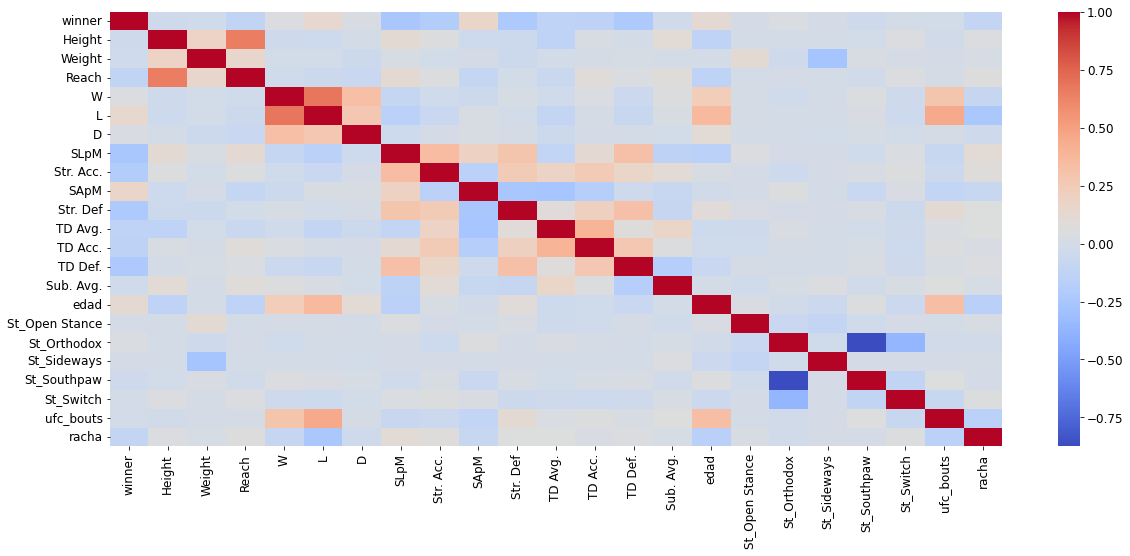

In [155]:
# Matriz de correlacion inicial
df_corr = df_clean[['winner'] + [col for col in df_clean.columns if col != 'winner']]

corr_matrix = df_corr.corr()

plt.figure(figsize=(20, 8))
sns.heatmap(corr_matrix, cmap = 'coolwarm')
plt.show()

In [165]:
corr_matrix['winner'].sort_values(ascending=False)

winner            1.000000
SApM              0.162135
L                 0.133215
edad              0.117681
W                 0.044750
St_Orthodox       0.039757
D                 0.027603
St_Sideways      -0.001032
St_Open Stance   -0.002896
St_Switch        -0.007968
ufc_bouts        -0.012408
Weight           -0.028062
Sub. Avg.        -0.030925
St_Southpaw      -0.038134
Height           -0.039423
racha            -0.101444
Reach            -0.113958
TD Avg.          -0.130220
TD Acc.          -0.139677
Str. Acc.        -0.196157
TD Def.          -0.223859
Str. Def         -0.226862
SLpM             -0.251267
Name: winner, dtype: float64

In [166]:
df_clean.columns

Index(['winner', 'Height', 'Weight', 'Reach', 'W', 'L', 'D', 'SLpM',
       'Str. Acc.', 'SApM', 'Str. Def', 'TD Avg.', 'TD Acc.', 'TD Def.',
       'Sub. Avg.', 'edad', 'ufc_bouts', 'racha', 'St_Open Stance',
       'St_Orthodox', 'St_Sideways', 'St_Southpaw', 'St_Switch'],
      dtype='object')

In [167]:
cols = ['winner', 'Height', 'Weight', 'Reach', 'W', 'L', 'D', 'SLpM', 'Str. Acc.', 'SApM',
       'Str. Def', 'TD Avg.', 'TD Acc.', 'TD Def.', 'Sub. Avg.', 'edad', 'ufc_bouts', 'racha',
       'St_Open Stance', 'St_Orthodox', 'St_Sideways', 'St_Southpaw',
       'St_Switch']

df_clean = df_clean[cols]
df_clean.head(1)

,winner,Height,Weight,Reach,W,L,D,SLpM,Str. Acc.,SApM,Str. Def,TD Avg.,TD Acc.,TD Def.,Sub. Avg.,edad,ufc_bouts,racha,St_Open Stance,St_Orthodox,St_Sideways,St_Southpaw,St_Switch
0,0,5.0,0.0,8.0,-22.0,-7.0,0.0,3.58,5.0,-1.08,-4.0,-2.11,-33.0,13.0,-0.9,-12.0,-16.0,4.0,0.0,-1.0,0.0,1.0,0.0


In [168]:
#Guardamos el modelo para entrenar el modelo
df_clean.to_csv('./df_final_1.csv', index=False)

#### Pasamos a ejecutar el notebook del modelo

# De aquí en adelante se muestra el codigo en sucio de creacion de nuevas estadisticas para discusion del proyecto en la defensa de la memoria

## VERSION 2: Intento de creacion de nuevas estadísticas segun los datos de cada pelea
#### Resultó en un empeoramiento del modelo hasta un 53%. NO se muestran los resultados en el notebook.

# 3. Data cleaning

## Dividir celdas peleadores. BOUTS.CSV

## FIGHTERS.CSV

# 4. Combinacion dataframes bouts y fighters

#### Añadir variable: ufc_bouts: numero de peleas dentro de ufc

* Categorizar el ganador (0 o 1)

* Merge fighters stats (permanentes) y estadisticas bouts

* Calculo edad en la pelea

* Sustituir NAs altura, peso, Reach, edad y stance

**Calculo estadisticas**

* Tiempo

* Finalizaciones variable

* Poner de nuevo el nombre del winner para el calculo posterior de finalizaciones

* Calculo estadisticas acumuladas. Golpes totales, tiempo total etc para calculo de estadisticas globales del peleador en esa fecha
* Calculo finalizaciones peleas y actualizacion victorias derrotas

## Merge con las estadisticas por peleas

* Se eliminan los peleadores duplicados

* Peleadores a eliminar: Bruno Silva, Michael McDonald, Joey Gomez, Mike Davis
* Marcus silveira y kazushi sakuraba tuvieron dos peleas el mismo dia (se duplicaran (dando 4) y habra que eliminarlas)

Hay una pelea menos ya que se elimina una de las peleas de Marcus silveira y kazushi sakuraba que fue el mismo dia

### Stance categorizar